In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
df = pd.read_csv('train_V2.csv')
df.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


In [2]:
#delete rows with missing values 
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna(axis = 0, how = 'any')

#check whether the dataset contains missing value or not
df.isna().any().any()



False

In [3]:
#encode matchType
type_map = {'solo' : 1, 'solo-fpp' : 1, 'duo' : 2, 'duo-fpp' : 2, 'squad' : 4, 'squad-fpp' : 4,\
            'normal-solo-fpp' : 1, 'normal-duo-fpp' : 2, 'normal-squad-fpp' : 4, 'flaretpp' : 4, 'flarefpp' : 4,\
            'crashtpp' : 2 , 'crashfpp' : 2, 'normal-solo' : 1, 'normal-duo' : 2, 'normal-squad' : 4}
df['matchType'] = df['matchType'].map(type_map)

In [4]:
#drop unused features
df = df.drop(['Id','groupId','matchId'],axis = 1)

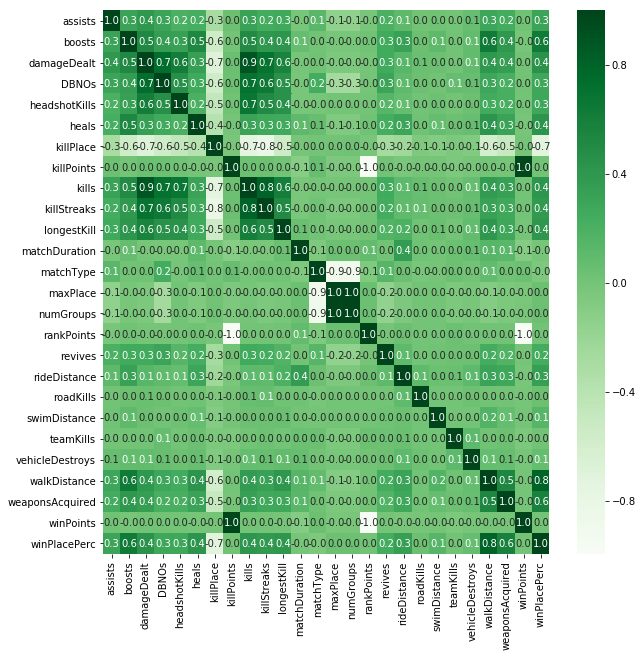

In [5]:
plt.figure(figsize = (10,10))
ax = sns.heatmap(df.corr(),annot = True, fmt = '.1f',cmap = 'Greens')
plt.savefig('heatmap', dpi=400, bbox_inches='tight')

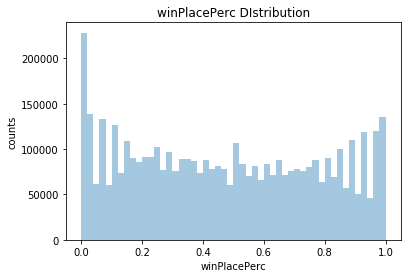

In [6]:
#plot winPlacePerc distribution
output = df.iloc[:,-1].values
his = sns.distplot(output, kde = False, rug = False)
plt.title('winPlacePerc DIstribution')
plt.xlabel('winPlacePerc')
plt.ylabel('counts')
plt.savefig('histogram', dpi=400, bbox_inches='tight')
plt.show()

In [7]:
#split feature and winPlacePerc
feature_df = df.iloc[:,:-1]

feature = df.iloc[: ,:-1].values
winPerc = df['winPlacePerc'].values



In [15]:
# GBDT Prediction
import lightgbm as lgb
params = {
    'n_estimators': 100,
    'learning_rate': 0.1, 
    'num_leaves': 20,
    'objective': 'regression_l2', 
    'metric': 'mae',
    'verbose': -1,
}
reg = lgb.LGBMRegressor(**params, boosting_type = 'gbdt')
reg.fit(feature,winPerc)
pred = reg.predict(feature, num_iteration=reg.best_iteration_)
err = 0
for i in range(len(pred)):
    err += (pred[i] - winPerc[i])*(pred[i] - winPerc[i])
err = np.sqrt(err / len(pred))
print(err)

0.0851004831766933


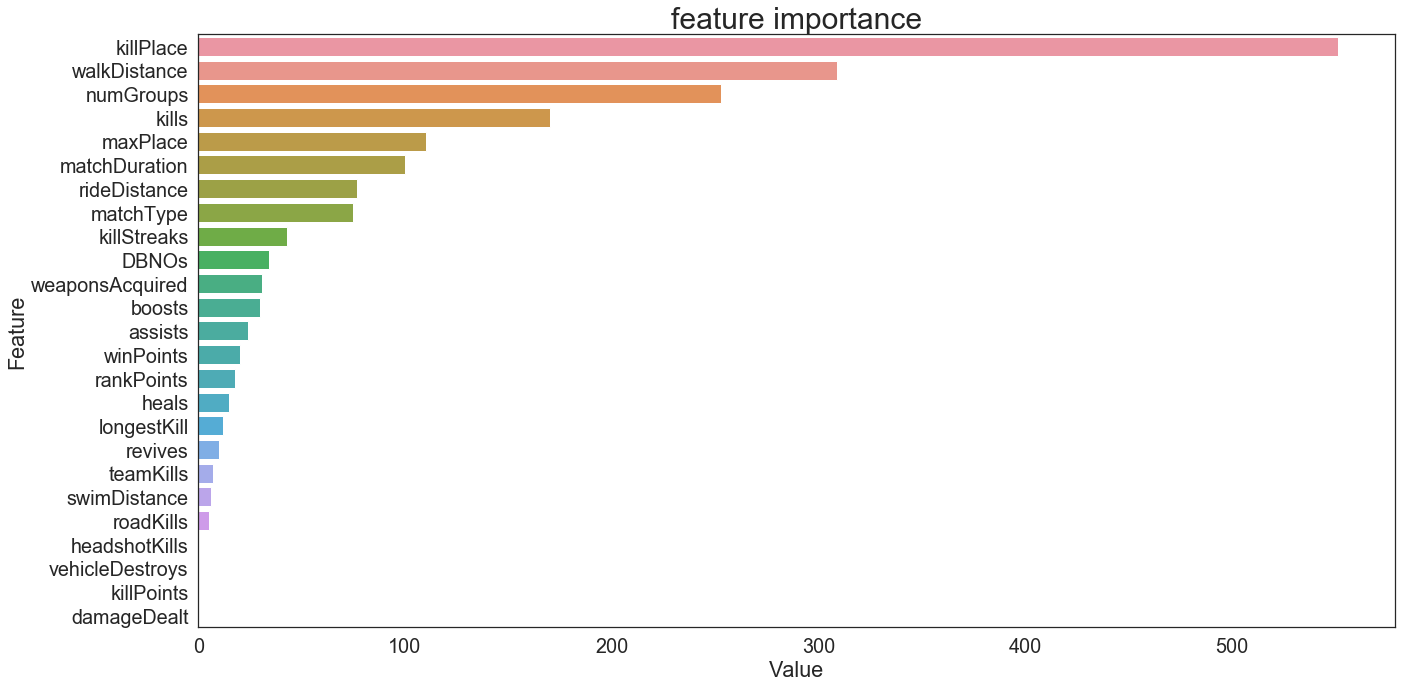

In [16]:
#feature importance
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
feature_imp = pd.DataFrame(sorted(zip(reg.feature_importances_,feature_df.columns)), columns=['Value','Feature'])
plt.figure(figsize=(20, 10))
sns.set(font_scale=1.8)
sns.set_style('white')
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('feature importance', {'fontsize':30})
plt.tight_layout()
plt.savefig('gbdtfimp', dpi=500, bbox_inches='tight')
plt.show()

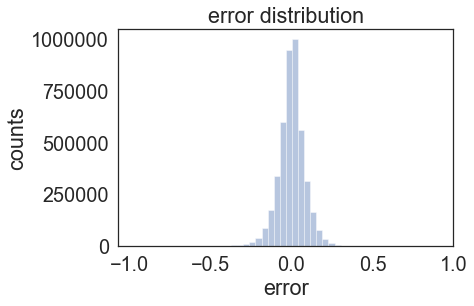

In [17]:
import seaborn as sns
err = pred - winPerc
his2 = sns.distplot(err, kde = False, rug = False)
plt.xlabel('error')
plt.ylabel('counts')
plt.title('error distribution')
plt.savefig('gbdt_error_dis', dpi = 1000, bbox_inches='tight')

In [11]:
# Random Forest Prediction
#params = {"bagging_freq" : 1, "bagging_fraction" : 0.5}

reg = lgb.LGBMRegressor(boosting_type = 'rf', bagging_freq = 1, bagging_fraction = 0.5)
reg.fit(feature,winPerc)
pred = reg.predict(feature, num_iteration=reg.best_iteration_)
err = 0
for i in range(len(pred)):
    err += (pred[i] - winPerc[i])*(pred[i] - winPerc[i])
err = np.sqrt(err / len(pred))
print(err)
print(len(pred))

0.116213006948395
4446965


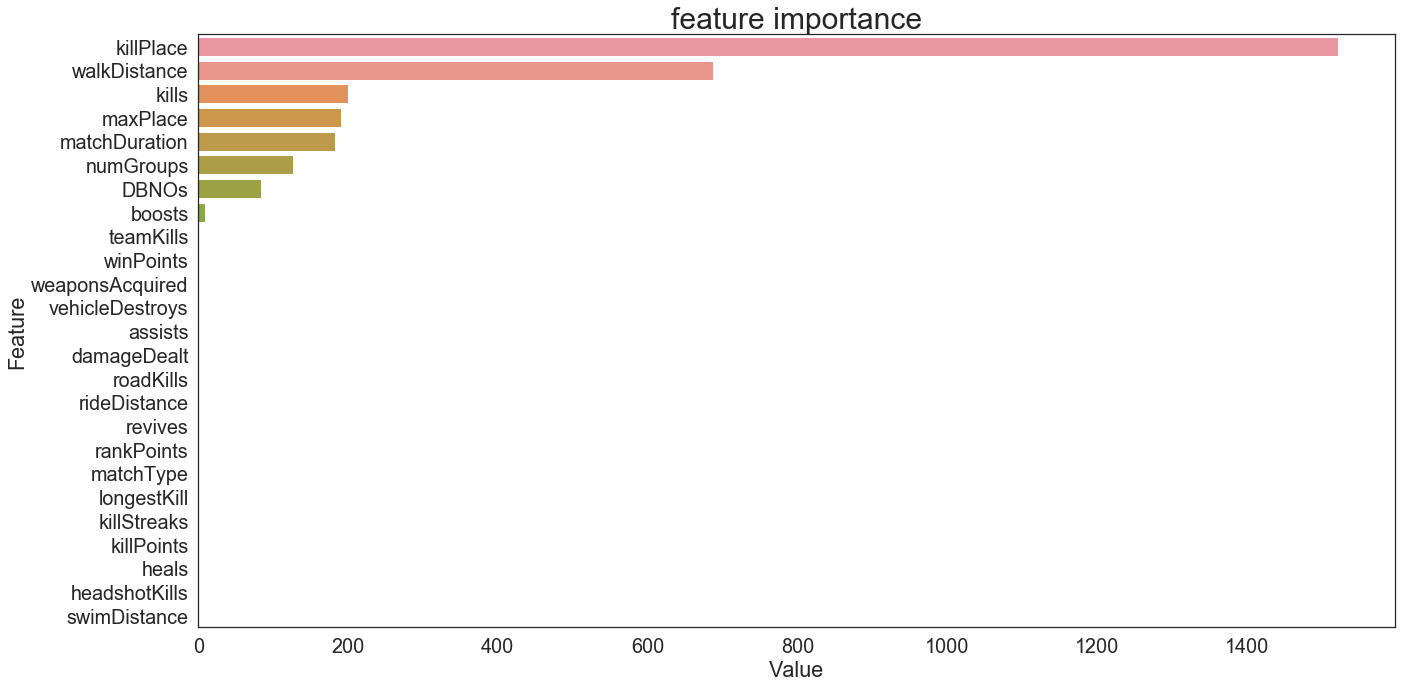

In [12]:
feature_imp = pd.DataFrame(sorted(zip(reg.feature_importances_,feature_df.columns)), columns=['Value','Feature'])
plt.figure(figsize=(20, 10))
sns.set(font_scale=1.8)
sns.set_style('white')
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('feature importance', {'fontsize' : 30})
plt.tight_layout()
#plt.savefig('feature importance', dpi=400, bbox_inches='tight')
plt.savefig('rffimp', dpi = 500)

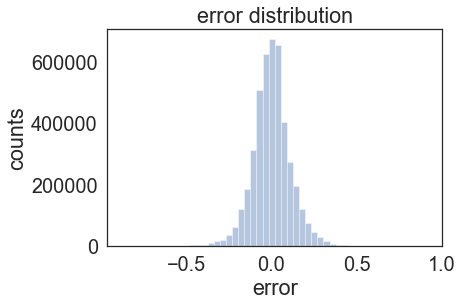

In [13]:
err = pred - winPerc
his2 = sns.distplot(err, kde = False, rug = False)
plt.xlabel('error')
plt.ylabel('counts')
plt.title('error distribution')
plt.savefig('rferrordis', dpi = 1000, bbox_inches = 'tight')

In [14]:
#compare to normal linear regression
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(feature, winPerc)
pred = reg.predict(feature)
err = 0
for i in range(len(pred)):
    err += (pred[i] - winPerc[i])*(pred[i] - winPerc[i])
err = np.sqrt(err / len(pred))
print(err)

0.12651874265055224
